# Monai Tutorial Notebook

In this notebook we copied part of Monai's tutorial code from here: https://github.com/Project-MONAI/tutorials/blob/master/modules/TorchIO_MONAI_PyTorch_Lightning.ipynb to build a small CNN for 3D images. For dataloading torchio is used which seems to be faster than the other dataloading libraries (niblabel, simpleitk) which was shown in the nifty data exploration notebook in ../notebooks/0_eda/. In the "MRIDataModule" preprocessing techniques can be defined. Currently, the files are too big for big computations, so they are resized. The training loop is managed by Pytorch Lightning which offers clearer building blocks to start the training or validation loops. To build the models we use Sequential Pytorch model blocks but Monai also offers some very advanced neural network blocks as well. They are all featured in the Monai Documentation:

https://docs.monai.io/en/stable/highlights.html#network-architectures and

https://docs.monai.io/en/stable/api.html

In [1]:
import sys
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime

import torchio as tio
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, utils
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, BatchSampler, Sampler

sys.path.insert(0, '../../models/')
sys.path.insert(0, '../../scripts/')
sys.path.insert(0, '../../')

import pytorch_lightning as pl
import monai

from helpers import miscellaneous as misc
from helpers import plotters
from helpers import preprocessing
CONFIG = misc.get_config()

from ModelUtils import EncoderCNN
from ModelUtils import CognitiveTestMLP
from ModelUtils import FusionModel

#get Loader.py
from Loader import MRIDataset

#get TrainUtils.py helpers
from TrainUtils import train

In [2]:
class MRIDataModule(pl.LightningDataModule):
    def __init__(self, task, batch_size, data_paths, include_preprocess = False, include_augment = False):
        super().__init__()
        self.task = task
        self.batch_size = batch_size
        self.data_paths = data_paths
        self.dataset_dir = Path(task)
        self.subjects = None
        self.test_subjects = None
        self.preprocess = None
        self.augment = None
        self.transform = None
        self.train_set = None
        self.test_set = None
        self.include_preprocess = include_preprocess
        self.include_augment = include_augment

    def get_preprocessing_transform(self):
        preprocess = tio.Compose([
            tio.RescaleIntensity((-1, 1)),
            tio.Resample((1,1,1)),
            tio.EnsureShapeMultiple(8),
            tio.Resize((10,10,10)),
            tio.OneHot()
        ])
        return preprocess

    def get_augmentation_transform(self):
        augment = tio.Compose([
                tio.RandomAffine(),
                tio.RandomGamma(p=0.5),
                tio.RandomNoise(p=0.5),
                tio.RandomMotion(p=0.1),
                tio.RandomBiasField(p=0.25),
            ])
        return augment

    def setup(self, stage=None):
        
        self.preprocess = self.get_preprocessing_transform() if self.include_preprocess else None
        self.augment = self.get_augmentation_transform() if self.include_augment else None
        
        if self.preprocess is not None and self.augment is not None:
            self.transform = tio.Compose([self.preprocess, self.augment])
        elif self.preprocess is None:
            self.transform = self.augment
        elif self.augment is None:
            self.transform = self.preprocess
        
        print(self.transform, self.preprocess)
        self.train_set = MRIDataset(self.data_paths['train_dir'], transform=self.transform)
        self.test_set = MRIDataset(self.data_paths['test_dir'], transform=self.preprocess)

    def train_dataloader(self):
        return DataLoader(self.train_set, self.batch_size, num_workers=12)

    def test_dataloader(self):
        return DataLoader(self.test_set, self.batch_size, num_workers=12)

In [21]:
batch_size = 1

data = MRIDataModule(
    task='TestMonai',
    batch_size= batch_size,
    data_paths = {'train_dir': "../../" + CONFIG['TRAIN_LABELS_DIR'],
                 'test_dir': "../../" + CONFIG['TEST_LABELS_DIR']},
    include_preprocess = False,
    include_augment = False
)

In [22]:
data.prepare_data()
data.setup()
print('Training:  ', len(data.train_set))
print('Test:      ', len(data.test_set))

None None
Training:   1114
Test:       263


In [23]:
class Model(pl.LightningModule):
    def __init__(self, net, criterion, learning_rate, optimizer_class):
        super().__init__()
        self.lr = learning_rate
        self.net = net
        self.criterion = criterion
        self.optimizer_class = optimizer_class

    def configure_optimizers(self):
        optimizer = self.optimizer_class(self.parameters(), lr=self.lr)
        return optimizer

    def prepare_batch(self, batch):
        return batch['images'], batch['labels']

    def infer_batch(self, batch):
        x, y = self.prepare_batch(batch)
        y_hat = self.net(x)
        return y_hat, y

    def training_step(self, batch, batch_idx):
        y_hat, y = self.infer_batch(batch)
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        print(loss)
        return loss

In [24]:
unet = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=3,
    channels=(8, 16, 32, 64),
    strides=(1, 1, 1),
)

"""model = Model(
    net=unet,
    criterion=monai.losses.DiceCELoss(softmax=True, to_onehot_y=True),
    learning_rate=1e-2,
    optimizer_class=torch.optim.AdamW,
)"""

early_stopping = pl.callbacks.early_stopping.EarlyStopping(
    monitor='train_loss',
)

trainer = pl.Trainer(
    max_epochs = 10,
    gpus=1,
    precision=16,
    callbacks=[early_stopping],
)
trainer.logger._default_hp_metric = False

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
conv = monai.networks.blocks.Convolution(
    dimensions=3,
    in_channels=1,
    out_channels=batch_size,
    adn_ordering="ADN",
    act=("prelu", {"init": 0.2}),
    dropout=0.1
)

conv_test = torch.nn.Sequential(        # Shapes
    nn.Conv3d(1, 32, 3),    # 32 x sr
    nn.ReLU(),
)

densenet = monai.networks.nets.DenseNet(
    spatial_dims = 3, 
    in_channels = 1, 
    out_channels = 1,      
)

cnn_to_mlp = nn.Sequential(
  nn.Flatten(1, -1),
  nn.Linear(batch_size*150*150*100 , 64),
  nn.ReLU(),
  nn.Linear(64, 32),
  nn.ReLU(),
  nn.Linear(32, 3),  
  nn.Softmax(dim=1)
)

model = nn.Sequential(
    conv,
    cnn_to_mlp
)

print(model)

model = Model(
    net=model,
    criterion= nn.functional.cross_entropy,
    learning_rate=0.001,
    optimizer_class=torch.optim.AdamW,
)

Sequential(
  (0): Convolution(
    (conv): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (adn): ADN(
      (A): PReLU(num_parameters=1)
      (D): Dropout(p=0.1, inplace=False)
      (N): InstanceNorm3d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    )
  )
  (1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2250000, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=3, bias=True)
    (6): Softmax(dim=1)
  )
)


In [26]:
start = datetime.now()
print('Training started at', start)
trainer.fit(model=model, datamodule=data)
print('Training duration:', datetime.now() - start)

Training started at 2022-04-19 13:03:57.265310
None None


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net  | Sequential | 144 M 
------------------------------------
144 M     Trainable params
0         Non-trainable params
144 M     Total params
288.005   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

tensor(1.1141, device='cuda:0', grad_fn=<DivBackward1>)


RuntimeError: CUDA out of memory. Tried to allocate 550.00 MiB (GPU 0; 4.00 GiB total capacity; 2.71 GiB already allocated; 0 bytes free; 2.72 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [43]:
from monai.visualize import CAM

cam = CAM(nn_module=model, target_layers="layer4", fc_layers="last_linear")
result = cam(x=torch.rand((2, 3, 48, 64)))

C:\Users\bruno\anaconda3\lib\site-packages\monai\visualize\class_activation_maps.py:93: UserWarning: Not all target_layers exist in the network module: targets: ('layer4',).
  warnings.warn(f"Not all target_layers exist in the network module: targets: {self.target_layers}.")


NotImplementedError: 

In [9]:
img = tio.ScalarImage(data.train_set.df.iloc[647].filename)
print(img)
transform = data.get_preprocessing_transform()

img = transform(img)

img

ScalarImage(shape: (1, 256, 256, 180); spacing: (0.94, 0.94, 1.21); orientation: IPL+; path: "..\..\data\raw\flattened\ADNI_021_S_0231_MR_MPR__GradWarp__N3__Scaled_Br_20070816120042598_S28705_I67969.nii")


ScalarImage(shape: (1, 10, 10, 10); spacing: (24.80, 24.80, 22.40); orientation: IPL+; dtype: torch.FloatTensor; memory: 3.9 KiB)

(array([817.,   0.,   0.,   0.,   0., 513.,   0.,   0.,   0., 368.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

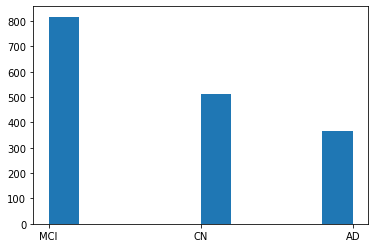

In [12]:
plt.hist(data.train_set.df.Group)

## Normal Image:

In [14]:
def show_slices(img_data):
    paramtools = {
        'i': IntSlider(min=0, max=img_data.shape[0]-1, step=1),
        'j': IntSlider(min=0, max=img_data.shape[1]-1, step=1),
        'k': IntSlider(min=0, max=img_data.shape[2]-1, step=1),
    }
    
    @interact(**paramtools)
    def show_interactive(i, j, k):
        fig, axes = plt.subplots(1, 3, figsize=(25,25))
        axes[0].imshow(img_data[i,:,:].T, cmap="magma", origin="lower")
        axes[1].imshow(img_data[:,j,:].T, cmap="magma", origin="lower")
        axes[2].imshow(img_data[:,:,k].T, cmap="magma", origin="lower")

import nibabel as nib

#img = tio.ScalarImage(data.train_set.df.iloc[648].filename)
img = nib.load(data.train_set.df.iloc[647].filename)
#img.data = img.data.to(torch.int64)
print(img)
#transform = data.get_preprocessing_transform()

#img = transform(img)

show_slices(img.get_fdata())

<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 256, 166)
affine: 
[[ 3.22026613e-08  2.45020353e-04 -1.20652326e+00  1.01537003e+02]
 [-2.46155907e-04 -9.36463053e-01 -3.15680094e-04  1.59494995e+02]
 [-9.40813092e-01  2.45017764e-04  4.12975332e-08  1.29677994e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'027_S_0307'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 166   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        0.9408131 0.9364631 1.2065233 1.        1.        1.
 1.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 

interactive(children=(IntSlider(value=0, description='i', max=255), IntSlider(value=0, description='j', max=25…

## Broken Image:

In [52]:
#img = tio.ScalarImage(data.train_set.df.iloc[648].filename)
print(data.train_set.df.iloc[648].filename)
img = nib.load(data.train_set.df.iloc[648].filename)
#img.data = img.data.to(torch.int64)
print(type(img))
#transform = data.get_preprocessing_transform()

#img = transform(img)

show_slices(img.get_fdata())

../../data/raw/flattened\ADNI_021_S_0141_MR_MPR__GradWarp__N3__Scaled_Br_20061217092830688_S11036_I33396.nii
<class 'nibabel.nifti1.Nifti1Image'>


interactive(children=(IntSlider(value=0, description='i', max=255), IntSlider(value=0, description='j', max=25…

In [13]:
#img = tio.ScalarImage(data.train_set.df.iloc[648].filename)
print(data.train_set.df.iloc[1433].filename)
img = nib.load(data.train_set.df.iloc[1433].filename)
#img.data = img.data.to(torch.int64)
print(img)
#transform = data.get_preprocessing_transform()

#img = transform(img)

show_slices(img.get_fdata())

../../data/raw/flattened\ADNI_010_S_0067_MR_MPR-R____N3__Scaled_Br_20070807151408143_S17808_I65577.nii
<class 'nibabel.nifti1.Nifti1Image'>
data shape (256, 256, 170)
affine: 
[[ 5.65740103e-08  5.01775928e-07 -1.20481300e+00  1.00159691e+02]
 [-2.08552309e-01 -9.13322776e-01 -6.45603180e-07  1.61614151e+02]
 [-9.21817228e-01  2.06630521e-01  7.21194275e-08  8.43791885e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='>'
sizeof_hdr      : 348
data_type       : b''
db_name         : b'010_S_0067'
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 256 256 170   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.        0.9451143 0.9364052 1.204813  1.        1.        1.
 1.       ]
vox_offset      : 0.0
scl_s

interactive(children=(IntSlider(value=0, description='i', max=255), IntSlider(value=0, description='j', max=25…